In [1]:
## Load in needed mods
## Bring in mutual information mods
from sklearn import feature_selection as fs

## Load in matplotlib
from matplotlib import pyplot as plt

## Import mods for analysis
import numpy as np, pandas as pd, scipy.stats as ss

In [2]:
## Load in phenotype data
## set path
phenopath = '../PHENOTYPE/PROCESSED/Cellsize_shape_phenotype_QTL.csv.gz'

## Load in dataframe
pheno = pd.read_csv(phenopath)

## Check that there are no clones
assert pheno.Clone.sum() == 0, "Clones present"

## View first 5 rows
pheno.head()

,Strain,Basidium,Phenotype_Short,Set,Phenotype_Description,Binary,Trinary,Quaternary,Genotyped,Clone,IRK7,RIC8,RHO,MAT
0,A_01,1.0,N,0.0,Yeast,0.0,0.0,0.0,A01,0,1.0,0.0,1.0,1.0
1,A_02,1.0,Y,0.0,Selfing,1.0,2.0,2.0,A02,0,0.0,1.0,1.0,0.0
2,A_03,1.0,N,0.0,Yeast,0.0,0.0,0.0,A03,0,0.0,0.0,0.0,0.0
3,A_04,1.0,L,0.0,Large Cell,1.0,1.0,1.0,A04,0,1.0,1.0,0.0,1.0
4,A_06,2.0,L,0.0,Large Cell,1.0,1.0,1.0,A06,0,1.0,1.0,0.0,1.0


In [3]:
## Set phenotype name
phenotype = 'Quaternary'

## Slice a bit of data
pheno_chr14 = pheno[[phenotype,'IRK7','RIC8']]

In [4]:
## Calculate the number of recombinant progeny
n_rec = pheno_chr14[['IRK7','RIC8']].diff(axis=1).abs().sum().max()
n_rec

15.0

In [5]:
## How many are recombinant (not including the three parental strains)
n_rec/(pheno_chr14.shape[0]-3)

0.21428571428571427

In [6]:
## Calculate bootstrapped MI observation
## Set boot straps
nboots = 1000

## initilize boot list
boots = []

## Loop thru bootstraps
while len(boots)<nboots:
    
    ## Sample progeny names
    temp = pheno_chr14.sample(pheno_chr14.shape[0],replace=True).copy()
    
    ## Calculate MI
    miobs = fs.mutual_info_classif(temp.values,temp[phenotype],discrete_features=True)
    
    ## Append list
    boots.append(miobs)
    
## Make into a dataframe
boots = pd.DataFrame(boots,columns=['Entropy','IRK7','RIC8'])

In [7]:
## Zip together variant positions
varpos = dict(zip(['IRK7','RIC8'],[134798,388777]))

In [8]:
## What is the 99th percentile 
np.percentile(boots[['IRK7','RIC8']].T.idxmax().replace(varpos),99)

388777.0

In [9]:
## Calculate the mean of the bootstraps
boots.mean()

Entropy    1.215911
IRK7       0.211268
RIC8       0.585657
dtype: float64

In [10]:
## How correlated are these two loci?
ss.spearmanr(pheno_chr14.IRK7.values,pheno_chr14.RIC8.values)

SpearmanrResult(correlation=0.5843492038624621, pvalue=5.713014256949314e-08)

In [11]:
## What is the true mutual information
## between IRK7 and RIC8
obs = fs.mutual_info_classif(pheno_chr14.IRK7.values.reshape(-1,1),
                       pheno_chr14.RIC8.values,
                       discrete_features=True)

## Print this MI
obs

array([0.18105694])

In [12]:
## Generate a null dist of mutual information
## between the two loci using 1000 permutations
perms = np.concatenate([fs.mutual_info_classif(np.random.permutation(pheno_chr14.IRK7.values.reshape(-1,1)),
                       pheno_chr14.RIC8.values,
                       discrete_features=True) for i in range(1000)])

In [13]:
## What percent of permuted MI is greater than the obsvered?
np.sum(perms > obs)/len(perms)

0.0

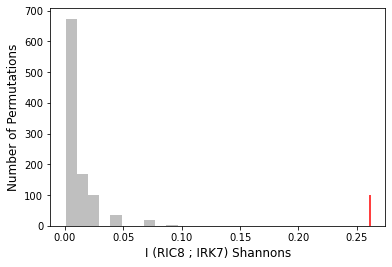

In [14]:
## Generate a hitogram showing the
## null distribution of MI and the true MI
## between RIC8 and IRK7
plt.hist(perms/np.log(2),color='grey',alpha=0.5);
plt.vlines(obs/np.log(2),0,len(perms)/10,color='r');
plt.ylabel('Number of Permutations',fontsize=12)
plt.xlabel('I (RIC8 ; IRK7) Shannons',fontsize=12);